In [1]:
# 数据分析
import pandas as pd 
import numpy as np
import pickle
from tqdm import *
from rqfactor import *
from scipy.stats import spearmanr

# 米筐
import rqsdk
from rqdatac import *
init()

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
def get_Performance_analysis(T,year_day = 252):
    # 获取最终净值
    net_values = round(T[-1],4)
    
    # 计算几何年化收益率
    year_ret_sqrt = net_values**(year_day/len(T))-1
    year_ret_sqrt = round(year_ret_sqrt*100,2)
    
    # 计算年化波动率
    volitiy = T.pct_change().dropna().std()*np.sqrt(year_day)
    volitiy = round(volitiy*100,2)
    
    #计算夏普，无风险收益率记3%
    Sharpe = (year_ret_sqrt - 3)/volitiy
    Sharpe = round(Sharpe,2)

    # 计算最大回撤
    # 最大回撤结束点
    i = np.argmax((np.maximum.accumulate(T) - T)/np.maximum.accumulate(T))
    # 开始点
    j = np.argmax(T[:i])

    downlow = round((1-T[i]/T[j])*100,2)

    # 输出
    return [net_values,year_ret_sqrt,Sharpe,downlow,volitiy]

In [3]:
start_date = '2018-01-01'
end_date = '2023-06-01'

universe = '000300.XSHG'

# 动态券池
def INDEX_FIX(start_date,end_date,index_item):
    """
    :param start_date: 开始日 -> str
    :param end_date: 结束日 -> str 
    :param index_item: 指数代码 -> str 
    :return index_fix: 动态因子值 -> unstack
    """
    
    index = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in index_components(index_item,start_date= start_date,end_date=end_date).items()])).T

    # 构建动态股票池 
    index_fix = index.unstack().reset_index().iloc[:,-2:]
    index_fix.columns = ['date','stock']
    index_fix.date = pd.to_datetime(index_fix.date)
    index_fix['level'] = True
    index_fix.dropna(inplace = True)
    index_fix = index_fix.set_index(['date','stock']).level.unstack()
    index_fix.fillna(False,inplace = True)

    return index_fix

index_fix = INDEX_FIX(start_date,end_date,universe)
stock_list = index_fix.columns.tolist()
date_list = index_fix.index.tolist()

In [4]:
barra_style = ['momentum','beta','book_to_price','earnings_yield','liquidity','size','residual_volatility','non_linear_size','leverage','growth']

In [5]:
barra_dict = pd.read_pickle('./data/barra_dict.pkl')
barra_return = pd.read_pickle('./data/barra_return.pkl')

In [6]:
def Valuation_spread(factor):
    factor = factor.mask(~index_fix)
    factor_top = factor.mask((factor.sub(factor.quantile(0.9,axis = 1),axis = 0)) < 0)
    factor_bottom = factor.mask(factor.sub(factor.quantile(0.1,axis = 1),axis = 0) > 0)
    # 估值因子
    bp = execute_factor(Factor('book_to_market_ratio_lf'),stock_list,start_date,end_date).mask(~index_fix)

    bp_spread = bp.mask(factor_top.isnull()).median(axis = 1) - bp.mask(factor_bottom.isnull()).median(axis = 1)

    return bp_spread

def Pairwise(factor):
    ret = get_price(stock_list,get_previous_trading_date(start_date,60),end_date,fields = 'close').close.unstack('order_book_id').pct_change().dropna(how = 'all')
    
    factor = factor.mask(~index_fix)
    factor_top = factor.mask((factor.sub(factor.quantile(0.9,axis = 1),axis = 0)) < 0)
    factor_bottom = factor.mask(factor.sub(factor.quantile(0.1,axis = 1),axis = 0) > 0)

    match_dict = {}

    for i in tqdm(date_list):
        start_date_temp = get_previous_trading_date(i,60)
        end_date_temp = i
        # 多头组配对相关性
        stock_list_top_temp = factor_top.loc[i].dropna().index.tolist()
        top_ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_top_temp]
        top_ret60['mean'] = top_ret60.mean(axis = 1)
        top_match = top_ret60.corr()['mean'].drop('mean').mean()
        # 空头组配对相关性
        stock_list_bottom_temp = factor_bottom.loc[i].dropna().index.tolist()
        bottom_ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_bottom_temp]
        bottom_ret60['mean'] = bottom_ret60.mean(axis = 1)
        bottom_match = bottom_ret60.corr()['mean'].drop('mean').mean()

        match_dict[i] = {'top':top_match,'bottom':bottom_match}

    match_df = pd.DataFrame(match_dict).T
    match_df['match'] = match_df['top'] + match_df['bottom']
    match_top_bottom = - match_df['match']
    match_top = - match_df['top']
    match_bottom = - match_df['bottom']

    return match_top_bottom,match_top,match_bottom

def Volatility(factor):
    ret = get_price(stock_list,get_previous_trading_date(start_date,60),end_date,fields = 'close').close.unstack('order_book_id').pct_change().dropna(how = 'all')
    
    factor = factor.mask(~index_fix)
    factor_top = factor.mask((factor.sub(factor.quantile(0.9,axis = 1),axis = 0)) < 0)
    factor_bottom = factor.mask(factor.sub(factor.quantile(0.1,axis = 1),axis = 0) > 0)

    std_dict = {}

    for i in tqdm(date_list):
        start_date_temp = get_previous_trading_date(i,60)
        end_date_temp = i
        # 多头组波动率
        stock_list_top_temp = factor_top.loc[i].dropna().index.tolist()
        top_ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_top_temp]
        top_ret60_std = top_ret60.mean(axis = 1).std()
        # 空头组波动率
        stock_list_bottom_temp = factor_bottom.loc[i].dropna().index.tolist()
        bottom_ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_bottom_temp]
        top_bottom_ret60_std = (top_ret60.mean(axis = 1) - bottom_ret60.mean(axis = 1)).std()
        # 市场组合收益率
        stock_list_temp = factor.loc[i].dropna().index.tolist()
        ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_temp]
        ret60_std = ret60.mean(axis = 1).std()

        std_dict[i] = {'top':top_ret60_std/ret60_std,'top_bottom':top_bottom_ret60_std/ret60_std}

    std_df = pd.DataFrame(std_dict).T
    std_top = std_df['top']
    std_top_bottom = std_df['top_bottom']

    return std_top,std_top_bottom

def Reversal(factor):
    ret = get_price(stock_list,get_previous_trading_date(start_date,60),end_date,fields = 'close').close.unstack('order_book_id').pct_change().dropna(how = 'all')
    
    factor = factor.mask(~index_fix)
    factor_top = factor.mask((factor.sub(factor.quantile(0.9,axis = 1),axis = 0)) < 0)
    #factor_bottom = factor.mask(factor.sub(factor.quantile(0.1,axis = 1),axis = 0) > 0)

    turn_dict = {}

    for i in tqdm(date_list):
        start_date_temp = get_previous_trading_date(i,252*3)
        end_date_temp = i
        # 多头组波动率
        stock_list_top_temp = factor_top.loc[i].dropna().index.tolist()
        top_ret756 = ret.loc[start_date_temp:end_date_temp][stock_list_top_temp]
        # 空头组波动率
        #stock_list_bottom_temp = factor_bottom.loc[i].dropna().index.tolist()
        #bottom_ret756 = ret.loc[start_date_temp:end_date_temp][stock_list_bottom_temp]
        top_ret756_value = (top_ret756.mean(axis = 1) + 1).cumprod()[-1] - 1
        #top_bottom_ret756 = ((top_ret756.mean(axis = 1) - bottom_ret756.mean(axis = 1)) + 1).cumprod()[-1] - 1

        turn_dict[i] = {'top':top_ret756_value}

    turn_df = pd.DataFrame(turn_dict).T
    turn_top = turn_df['top']

    return turn_top

In [7]:
def crowd(factor,name):
    print('loading valuation_spread ...')
    bp_spread = Valuation_spread(factor)
    print('loading pairwise ...')
    match_top_bottom,match_top,match_bottom = Pairwise(factor)
    print('loading volatility ...')
    std_top,std_top_bottom = Volatility(factor)
    print('loading reversal ...')
    turn_top = Reversal(factor)

    factor_ret5 = barra_return[name].rolling(5).sum().shift(-5)
    factor_ret20 = barra_return[name].rolling(20).sum().shift(-20)
    factor_ret60 = barra_return[name].rolling(60).sum().shift(-60)

    df = pd.concat([bp_spread.to_frame('bp_spread'),
                    match_top_bottom.to_frame('match_top_bottom'),
                    match_top.to_frame('match_top'),
                    match_bottom.to_frame('match_bottom'),
                    std_top.to_frame('std_top'),
                    std_top_bottom.to_frame('std_top_bottom'),
                    turn_top.to_frame('turn_top'),
                    factor_ret5.to_frame('factor_ret5'),
                    factor_ret20.to_frame('factor_ret20'),
                    factor_ret60.to_frame('factor_ret60'),
                    ],axis = 1)
    
    df.columns.names = [name]
    
    return df

In [8]:
from sklearn.model_selection import train_test_split    #训练集拆分   经济学意义 
from sklearn.model_selection import KFold,cross_validate
from sklearn.ensemble import RandomForestClassifier     #随机森林

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report

### BARRA因子滚动识别

In [15]:
barra_x_test_predict_ret_20 = pd.DataFrame()
for f in barra_style:
    print(f)
    barra_single_factor = barra_dict[f].mask(~index_fix)
    barra_single_factor_crowd = crowd(barra_single_factor,f)

    factor_ret20 = barra_return[f].rolling(20).sum().shift(-20)
    barra_single_factor_crowd = barra_single_factor_crowd.dropna()
    barra_single_factor_crowd['target'] = (factor_ret20 > 0).astype(int)

    print('ml loading ...')
    num = barra_single_factor_crowd.shape[0]

    x_test_predict_ret_20 = pd.DataFrame()
    randomforest_acc_score = []
    for i in range(240,num-20,20):
        barra_single_factor_crowd_slice =barra_single_factor_crowd.iloc[i - 240:i+20]
        x_train =barra_single_factor_crowd_slice.loc[:,'bp_spread':'turn_top'].iloc[:240]
        y_train =barra_single_factor_crowd_slice.loc[:,'target'].iloc[:240]
        x_test =barra_single_factor_crowd_slice.loc[:,'bp_spread':'turn_top'].iloc[240:]
        y_test =barra_single_factor_crowd_slice.loc[:,'target'].iloc[240:]
        features = x_train.columns    

        rf_grid = {
                'max_depth':np.arange(3,15,3),
                'ccp_alpha':np.logspace(-5,-1,5)
                }

        rf_gscv = GridSearchCV(RandomForestClassifier(n_estimators = 50,max_features = 'sqrt',random_state = 0),
                                param_grid=rf_grid,
                                cv=5,
                                n_jobs = -1,
                                verbose=True,
                                )

        rf_gscv.fit(x_train, y_train)
        rf = rf_gscv.best_estimator_
        rf.fit(x_train, y_train)
        randomforest_predicted = rf.predict(x_test)
        #randomforest_conf_matrix = confusion_matrix(y_test, randomforest_predicted)
        #randomforest_acc_score.append(accuracy_score(y_test, randomforest_predicted))

        x_test['predict'] = randomforest_predicted
        x_test_predict_ret_20 = pd.concat([x_test_predict_ret_20,x_test['predict']],axis = 0)
    x_test_predict_ret_20.columns = [f]
    barra_x_test_predict_ret_20 = pd.concat([barra_x_test_predict_ret_20,x_test_predict_ret_20],axis = 1)

barra_x_test_predict_ret_20.to_pickle('barra_x_test_predict_ret_20.pkl')

momentum
loading valuation_spread ...
loading pairwise ...


100%|██████████| 1314/1314 [00:03<00:00, 331.83it/s]


loading volatility ...


100%|██████████| 1314/1314 [00:03<00:00, 383.42it/s]


loading reversal ...


100%|██████████| 1314/1314 [00:01<00:00, 1096.65it/s]


ml loading ...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 10

100%|██████████| 1314/1314 [00:04<00:00, 275.87it/s]


loading volatility ...


100%|██████████| 1314/1314 [00:04<00:00, 307.37it/s]


loading reversal ...


100%|██████████| 1314/1314 [00:01<00:00, 679.47it/s]


ml loading ...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 10

100%|██████████| 1314/1314 [00:06<00:00, 194.02it/s]


loading volatility ...


100%|██████████| 1314/1314 [00:05<00:00, 250.43it/s]


loading reversal ...


100%|██████████| 1314/1314 [00:01<00:00, 732.93it/s]


ml loading ...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 10

100%|██████████| 1314/1314 [00:04<00:00, 327.84it/s]


loading volatility ...


100%|██████████| 1314/1314 [00:03<00:00, 394.04it/s]


loading reversal ...


100%|██████████| 1314/1314 [00:01<00:00, 1096.34it/s]


ml loading ...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 10

100%|██████████| 1314/1314 [00:05<00:00, 261.31it/s]


loading volatility ...


100%|██████████| 1314/1314 [00:03<00:00, 342.14it/s]


loading reversal ...


100%|██████████| 1314/1314 [00:01<00:00, 1014.14it/s]


ml loading ...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 10

100%|██████████| 1314/1314 [00:05<00:00, 229.91it/s]


loading volatility ...


100%|██████████| 1314/1314 [00:04<00:00, 312.29it/s]


loading reversal ...


100%|██████████| 1314/1314 [00:01<00:00, 709.16it/s]


ml loading ...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 10

100%|██████████| 1314/1314 [00:04<00:00, 304.04it/s]


loading volatility ...


100%|██████████| 1314/1314 [00:03<00:00, 380.35it/s]


loading reversal ...


100%|██████████| 1314/1314 [00:01<00:00, 1150.92it/s]


ml loading ...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 10

100%|██████████| 1314/1314 [00:10<00:00, 129.04it/s]


loading volatility ...


100%|██████████| 1314/1314 [00:09<00:00, 144.05it/s]


loading reversal ...


100%|██████████| 1314/1314 [00:02<00:00, 599.00it/s]


ml loading ...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 10

100%|██████████| 1314/1314 [00:05<00:00, 256.43it/s]


loading volatility ...


100%|██████████| 1314/1314 [00:04<00:00, 278.71it/s]


loading reversal ...


100%|██████████| 1314/1314 [00:01<00:00, 755.21it/s]


ml loading ...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 10

100%|██████████| 1314/1314 [00:05<00:00, 258.16it/s]


loading volatility ...


100%|██████████| 1314/1314 [00:03<00:00, 345.41it/s]


loading reversal ...


100%|██████████| 1314/1314 [00:01<00:00, 1054.22it/s]


ml loading ...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 10

In [6]:
barra_x_test_predict_ret_20 = pd.read_pickle('barra_x_test_predict_ret_20.pkl')

In [7]:
barra_x_test_predict_ret_20

,momentum,beta,book_to_price,earnings_yield,liquidity,size,residual_volatility,non_linear_size,leverage,growth
2018-12-26,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2018-12-27,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2018-12-28,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2019-01-02,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2019-01-03,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2023-02-07,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2023-02-08,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2023-02-09,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2023-02-10,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


In [32]:
# 不可以做空
net = barra_return.mul(barra_x_test_predict_ret_20.shift(1),axis = 0).dropna(how = 'all').replace(0,np.nan).mean(axis = 1) 
net = pd.concat([net.to_frame('barra_crowd_fix_return'),barra_return.mean(axis = 1).to_frame('barra_return')],axis = 1).dropna()
cum_net = (net + 1).cumprod()
cum_net['alpha'] = cum_net['barra_crowd_fix_return']/cum_net['barra_return']

,净值,年化收益率,夏普比率,最大回测,波动率
barra_crowd_fix_return,1.2794,6.41,1.55,1.41,2.20
barra_return,1.0248,0.62,-1.62,1.77,1.47
alpha,1.2484,5.76,1.72,1.17,1.60


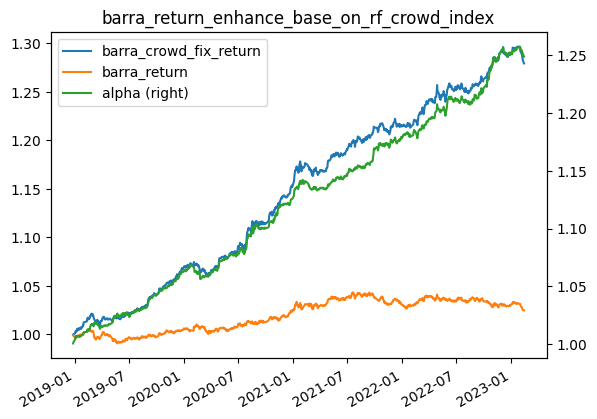

In [33]:
cum_net.plot(secondary_y='alpha',title='barra_return_enhance_base_on_rf_crowd_index')
performance = pd.DataFrame()
for i in cum_net.columns.tolist():
    temp = pd.DataFrame(get_Performance_analysis(cum_net[i]),columns= [i]).T
    performance = pd.concat([performance,temp],axis = 0)
performance.columns = ['净值','年化收益率','夏普比率','最大回测','波动率']

performance

<AxesSubplot: xlabel='date'>

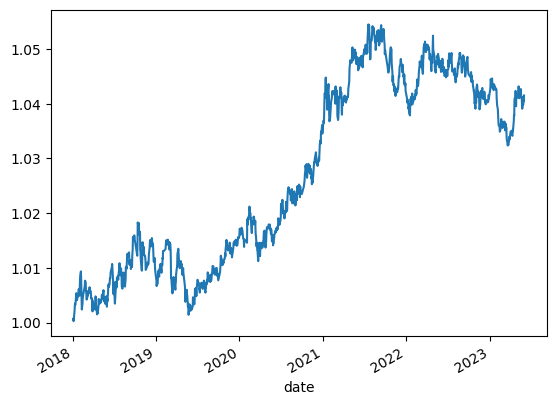

In [11]:
# 原始因子
(barra_return.mean(axis = 1) + 1).cumprod().plot()

### 随机森林基于拥挤度数据对于每个BARRA因子收益的预测表现
#### 汇总

<AxesSubplot: >

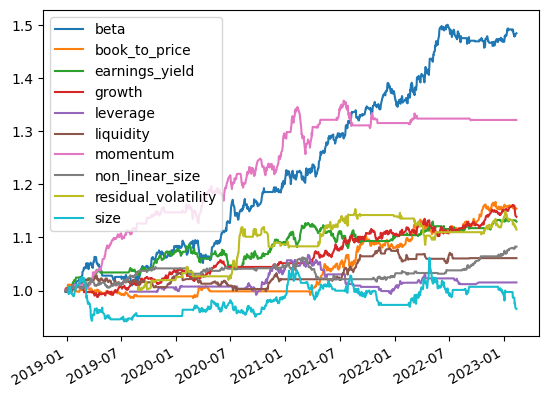

In [12]:
# 随机森林修正后的结构
barra_net = barra_return.mul(barra_x_test_predict_ret_20.shift(1),axis = 0).dropna(how = 'all').replace(0,np.nan)
barra_net = (barra_net + 1).cumprod().ffill()
barra_net.plot()

<AxesSubplot: xlabel='date'>

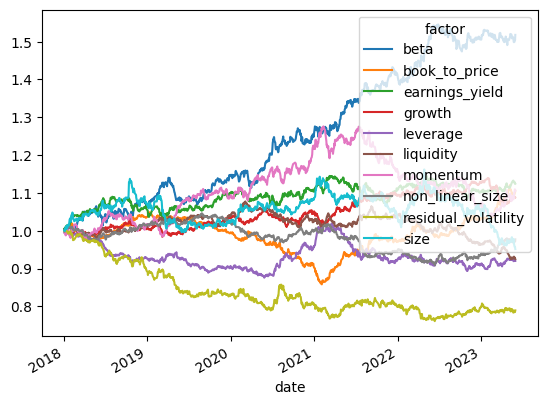

In [13]:
# 原始表现
(barra_return + 1).cumprod().plot()

In [20]:
barra_net = barra_return.mul(barra_x_test_predict_ret_20.shift(1),axis = 0).dropna(how = 'all').replace(0,np.nan)

#### 明细

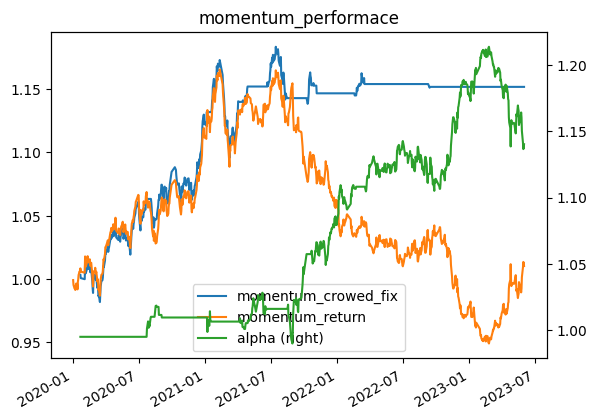

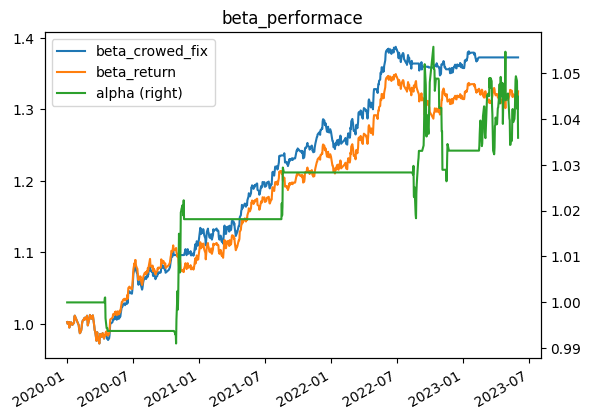

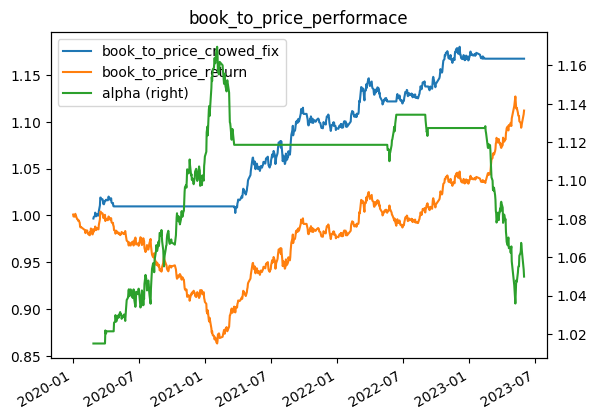

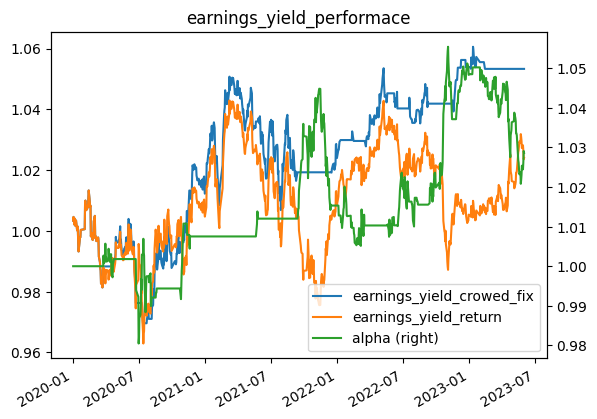

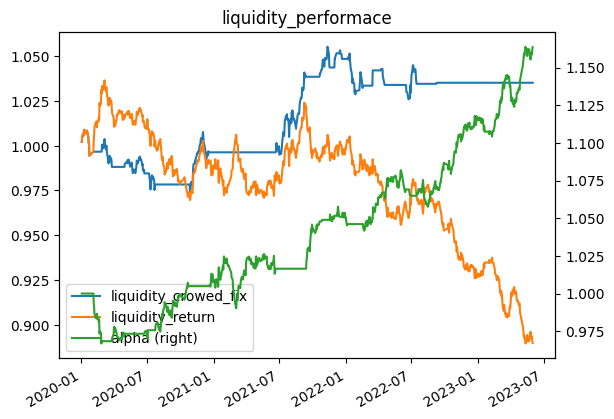

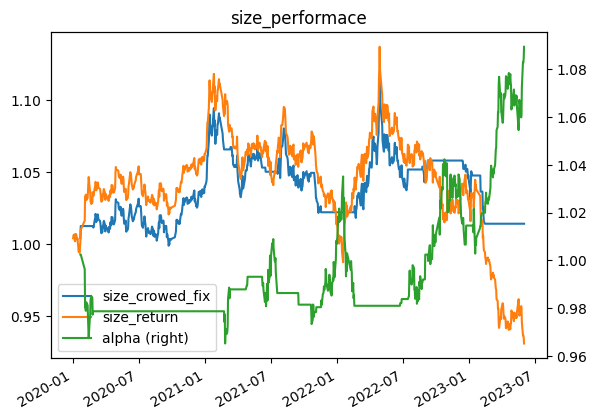

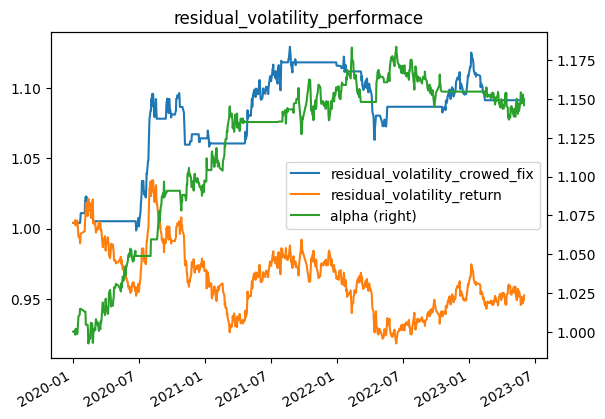

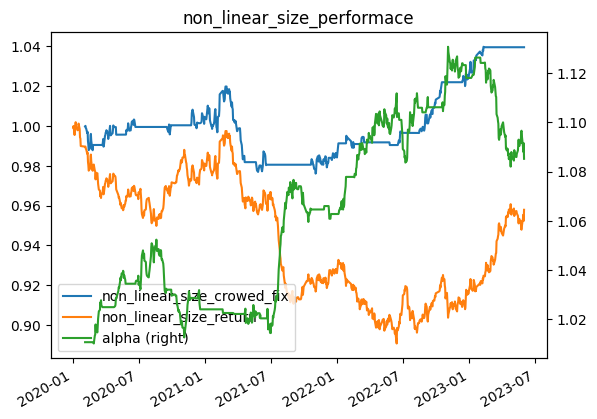

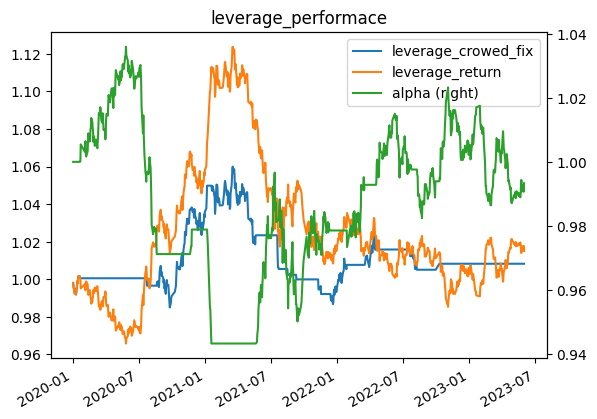

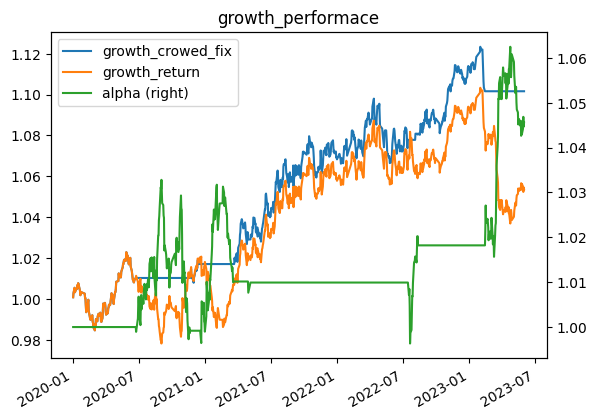

In [28]:
for i in barra_style:
    df_temp = pd.concat([barra_net[i].to_frame(f'{i}_crowed_fix'),barra_return[i].to_frame(f'{i}_return')],axis = 1).loc['2020-01-01':]
    df_temp = (df_temp+1).cumprod().ffill()
    df_temp['alpha'] = df_temp[f'{i}_crowed_fix']/df_temp[f'{i}_return']
    df_temp.plot(title = f'{i}_performace',secondary_y='alpha')